# Homework 3: Augmented Reality with Planar Homographies

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q2**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Q1 Preliminaries

## Q1.1 The Direct Linear Transform


### Q1.1.1 (3 points)

How many degrees of freedom does **h** have?

---

h has 8 degrees of freedom as it is a reshaped column vector from a 3x3 matrix homography matrix.

---

### Q1.1.2 (2 points)

How many point pairs are required to solve **h**?

---

4 point pairs are required

---

### Q1.1.3 (5 points)

Derive $\textbf{A}_i$

---

YOUR ANSWER HERE...

---

### Q1.1.4 (5 points)

What will be the trivial solution for **h**? Is the matrix **A** full rank? Why/Why not? What impact will it have on the singular values (i.e. eigenvalues of $\textbf{A}^T\textbf{A}$)?

---

The trivial solution of h is a zero vector. A is not full rank, since the first three columns (0-2) are not linearly independent from the the second three columns (3-5).

There are some identical columns.

There will be multiple zero singular values due to the matrix not being full rank.

---

## Q1.2 Homography Theory Questions

### Q1.2.1 (5 points)

Prove that there exists a homography **H** that satisfies $\textbf{x}_1 ≡ \textbf{Hx}_2$, given two cameras separated by a pure rotation.

---

YOUR ANSWER HERE...

---

### Q1.2.2 (5 points):

Show that $\textbf{H}^2$ is the homography corresponding to a rotation of 2$\theta$.

---

YOUR ANSWER HERE...

---

# Initialization

Run the following code to import the modules you'll need.

In [1]:
import os
import numpy as np
import cv2
import skimage.color
import pickle
from matplotlib import pyplot as plt
import scipy
from skimage.util import montage
import time
from random import sample

PATCHWIDTH = 9

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def write_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

def briefMatch(desc1,desc2,ratio):

    matches = skimage.feature.match_descriptors(desc1,desc2,
                                                'hamming',
                                                cross_check=True,
                                                max_ratio=ratio)
    return matches

def plotMatches(img1,img2,matches,locs1,locs2):

    fig, ax = plt.subplots(nrows=1, ncols=1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    skimage.feature.plot_matches(ax,img1,img2,locs1,locs2,
                                 matches,matches_color='r',only_matches=True)
    plt.show()
    return

def makeTestPattern(patchWidth, nbits):

    np.random.seed(0)
    compareX = patchWidth*patchWidth * np.random.random((nbits,1))
    compareX = np.floor(compareX).astype(int)
    np.random.seed(1)
    compareY = patchWidth*patchWidth * np.random.random((nbits,1))
    compareY = np.floor(compareY).astype(int)

    return (compareX, compareY)

def computePixel(img, idx1, idx2, width, center):

    halfWidth = width // 2
    col1 = idx1 % width - halfWidth
    row1 = idx1 // width - halfWidth
    col2 = idx2 % width - halfWidth
    row2 = idx2 // width - halfWidth
    return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0

def computeBrief(img, locs):

    patchWidth = 9
    nbits = 256
    compareX, compareY = makeTestPattern(patchWidth,nbits)
    m, n = img.shape

    halfWidth = patchWidth//2

    locs = np.array(list(filter(lambda x: halfWidth <= x[0] < m-halfWidth and halfWidth <= x[1] < n-halfWidth, locs)))
    desc = np.array([list(map(lambda x: computePixel(img, x[0], x[1], patchWidth, c), zip(compareX, compareY))) for c in locs])

    return desc, locs

def corner_detection(img, sigma):

    # fast method
    result_img = skimage.feature.corner_fast(img, n=PATCHWIDTH, threshold=sigma)
    locs = skimage.feature.corner_peaks(result_img, min_distance=1)
    return locs

def loadVid(path):

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name

    cap = cv2.VideoCapture(path)

    # get fps, width, and height
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Append frames to list
    frames = []

    # Check if camera opened successfully
    if cap.isOpened()== False:
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            #Store the resulting frame
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    frames = np.stack(frames)

    return frames, fps, width, height

# Download data

Download the required data and setup the results directory. If running on colab, DATA_PARENT_DIR must be <br> DATA_PARENT_DIR = '/content/' <br> <br> Otherwise, use the local directory of your choosing. Data will be downloaded to DATA_PARENT_DIR/hw3_data and a subdirectory DATA_PARENT_DIR/results will be created.

In [2]:
# Only change this if you are running locally
# Default on colab: DATA_PARENT_DIR = '/content/'

# Data will be downloaded to DATA_PARENT_DIR/hw3_data
# A subdirectory DATA_PARENT_DIR/results will be created

DATA_PARENT_FOLDER_DIR = 'data'
DATA_PARENT_DIR = os.getcwd()
print(DATA_PARENT_DIR)
DATA_PARENT_DIR = os.path.join(DATA_PARENT_DIR,DATA_PARENT_FOLDER_DIR)
print(DATA_PARENT_DIR)

if not os.path.exists(DATA_PARENT_DIR):
  raise RuntimeError('DATA_PARENT_DIR does not exist: ', DATA_PARENT_DIR)

RES_DIR = os.path.join(DATA_PARENT_DIR, 'results')
if not os.path.exists(RES_DIR):
  os.mkdir(RES_DIR)
  print('made directory: ', RES_DIR)


#paths different files are saved to
# OPTIONAL:
# feel free to change if funning locally
ROT_MATCHES_PATH = os.path.join(RES_DIR, 'brief_rot_test.pkl')
ROT_INV_MATCHES_PATH = os.path.join(RES_DIR, 'ec_brief_rot_inv_test.pkl')
AR_VID_FRAMES_PATH = os.path.join(RES_DIR, 'q_3_1_frames.npy')
AR_VID_FRAMES_EC_PATH = os.path.join(RES_DIR, 'q_3_2_frames.npy')

HW3_SUBDIR = ''
DATA_DIR = os.path.join(DATA_PARENT_DIR, HW3_SUBDIR)
ZIP_PATH = DATA_DIR + '.zip'
# if not os.path.exists(DATA_DIR):
#   !wget 'https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip' -O $ZIP_PATH
#   !unzip -qq $ZIP_PATH -d $DATA_PARENT_DIR

c:\Users\Ian Krause\Documents\GitHub\computer-vision\hw3
c:\Users\Ian Krause\Documents\GitHub\computer-vision\hw3\data


# Q2 Computing Planar Homographies

## Q2.1 Feature Detection and Matching

### Q2.1.1 (5 points):

How is the FAST detector different from the Harris corner detector that you've seen in the lectures? Can you comment on its computation performance compared to the Harris corner detector?

---

The FAST detector is not a computational approach so much as a logic/algorithmic based approach. It should be faster, given that it simply makes decisions based upon pixel values in an image versus calculating traces and determinants or even eigenvalues.

---

### Q2.1.2 (5 points):

How is the BRIEF descriptor different from the filterbanks you've seen in the lectures? Could you use any one of the those filter banks as a descriptor?

---

It is different in that it is very computationally efficient.

Technically any of these descriptors would work in place of BRIEF.

---

### Q2.1.3 (5 points):

Describe how the Hamming distance and Nearest Neighbor can be used to match interest points with BRIEF descriptors. What benefits does the Hamming distance have over a more conventional Euclidean distance measure in our setting?

---

BRIEF descriptors can represent our data.

A nearest neighbor search/evaluation can occur with a distance metric of Hamming distance.

Hamming distance is preferable because it can work better in a binary setting.

---

### Q2.1.4 (10 points):

#### Implement the function matchPics()

In [3]:
def matchPics(I1, I2, ratio, sigma):
    """
    Match features across images

    Input
    -----
    I1, I2: Source images (RGB or Grayscale uint8)
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector

    Returns
    -------
    matches: List of indices of matched features across I1, I2 [p x 2]
    locs1, locs2: Pixel coordinates of matches [N x 2]
    """

    # ===== your code here! =====

    # TODO: Convert images to GrayScale
    # Input images can be either RGB or Grayscale uint8 (0 -> 255). Both need
    # to be supported.
    # Input images must be converted to normalized Grayscale (0.0 -> 1.0)
    # skimage.color.rgb2gray may be useful if the input is RGB.
    if (len(I1.shape) > 2):
        if (I1.shape[2] == 3):
            I1 = skimage.color.rgb2gray(I1)
    if (len(I2.shape) > 2):
        if (I2.shape[2] == 3):
            I2 = skimage.color.rgb2gray(I2)

    # TODO: Detect features in both images
    locs1 = corner_detection(I1,sigma)
    locs2 = corner_detection(I2,sigma)

    # TODO: Obtain descriptors for the computed feature locations
    desc1, locs1 = computeBrief(I1,locs1)
    desc2, locs2 = computeBrief(I2,locs2)

    # TODO: Match features using the descriptors
    matches = briefMatch(desc1,desc2,ratio)

    # ==== end of code ====

    return matches, locs1, locs2

#### Implement the function displayMatched

In [4]:
def displayMatched(I1, I2, ratio, sigma):
    """
    Displays matches between two images

    Input
    -----
    I1, I2: Source images
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    """

    print('Displaying matches for ratio: ', ratio, ' and sigma: ', sigma)

    # ===== your code here! =====
    # TODO: Use matchPics and plotMatches to visualize your results
    matches, locs1, locs2 = matchPics(I1, I2, ratio, sigma)
    
    plotMatches(I1,I2,matches,locs1,locs2)
    # ==== end of code ====


#### Visualize the matches

Use the cell below to visualize the matches. The resulting figure should look similar (but not necessarily identical) to Figure 2.

Feel free to play around with the images and parameters. Please use the original images when submitting the report.

Figure 2 parameters:

*   image1_name = "cv_cover.jpg"
*   image1_name = "cv_desk.png"
*   ratio = 0.7
*   sigma = 0.15

Displaying matches for ratio:  0.7  and sigma:  0.15


C:\Users\Ian Krause\AppData\Local\Temp\ipykernel_19708\50834013.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


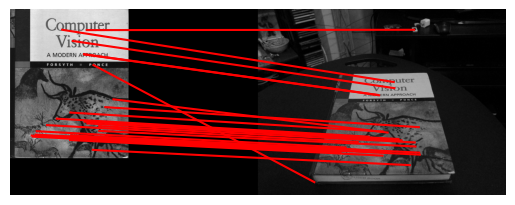

<class 'float'>
<class 'float'>


In [5]:
# Feel free to play around with these parameters
# BUT when submitting the report use the original images
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

displayMatched(image1, image2, ratio, sigma)
print(type(sigma))
print(type(ratio))

### Q2.1.5 (10 points):

Experiment with different sigma and ratio values. Conduct a small ablation study, and include the figures displaying the matched features with various parameters in your write-up. Explain the effect of these two paremeters respectively.

---

Explain the effect of these two parameters: YOUR ANSWER HERE...

---

Displaying matches for ratio:  0.6  and sigma:  0.1


C:\Users\Ian Krause\AppData\Local\Temp\ipykernel_19708\50834013.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


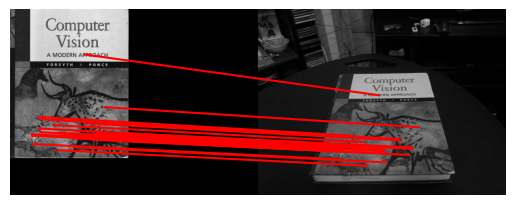

Displaying matches for ratio:  0.7  and sigma:  0.1


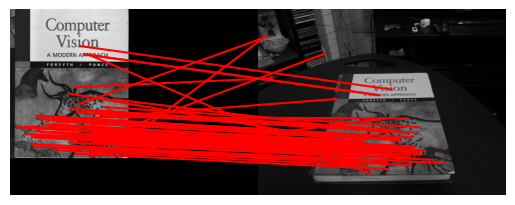

Displaying matches for ratio:  0.8  and sigma:  0.1


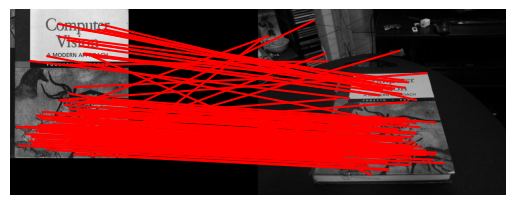

Displaying matches for ratio:  0.6  and sigma:  0.15


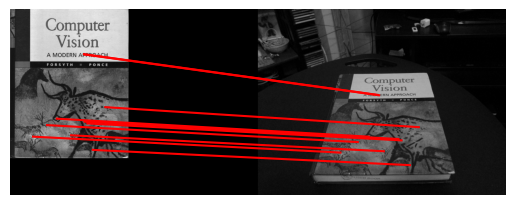

Displaying matches for ratio:  0.7  and sigma:  0.15


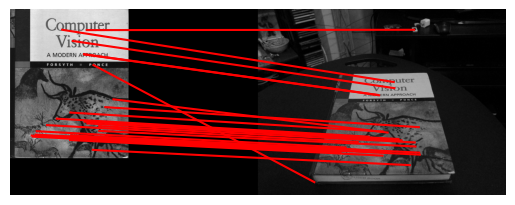

Displaying matches for ratio:  0.8  and sigma:  0.15


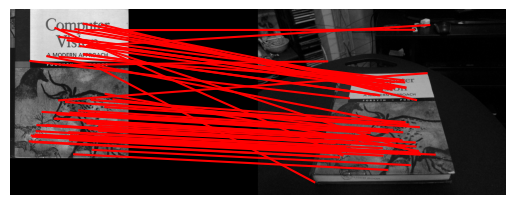

Displaying matches for ratio:  0.6  and sigma:  0.2


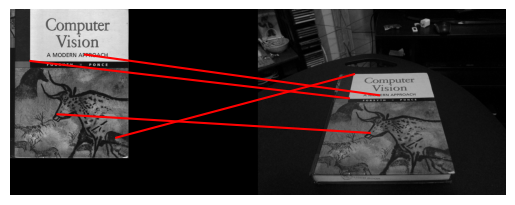

Displaying matches for ratio:  0.7  and sigma:  0.2


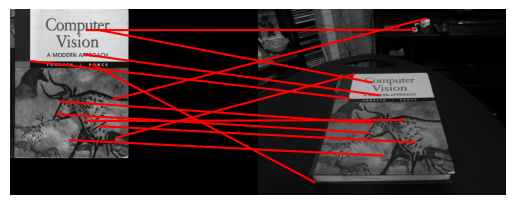

Displaying matches for ratio:  0.8  and sigma:  0.2


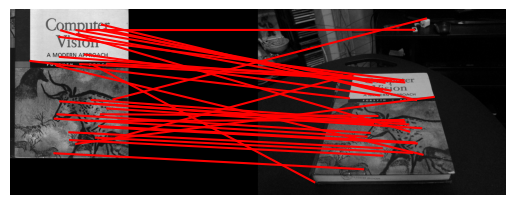

In [6]:
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# ===== your code here! =====
# Experiment with different sigma and ratio values.
# Use displayMatches to visualize.
# Include the matched feature figures in the write-up.
ratio_permutation = [0.6, 0.7, 0.8]
sigma_permutation = [0.1, 0.15, 0.2]

for sigmaVal in sigma_permutation:
  for ratioVal in ratio_permutation:
    displayMatched(image1, image2, ratioVal, sigmaVal)
# ==== end of code ====

---

Discuss the ablation study: YOUR ANSWER HERE...

---

### Q2.1.6 (10 points):

#### Implement the function briefRot

In [7]:
def briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Tests Brief with rotations.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    # Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # ===== your code here! =====
        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        rotIm = scipy.ndimage.rotate(image,i)

        # TODO: Match features in images
        matches, locs1, locs2 = matchPics(image,rotIm,ratio,sigma)

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        plotMatches(image,rotIm,matches,locs1,locs2)

        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(matches.shape[0])

        # ==== end of code ====

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    #plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)], weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

#### Visualize the matches under rotation

See debugging tips in handout.


0


C:\Users\Ian Krause\AppData\Local\Temp\ipykernel_19708\50834013.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


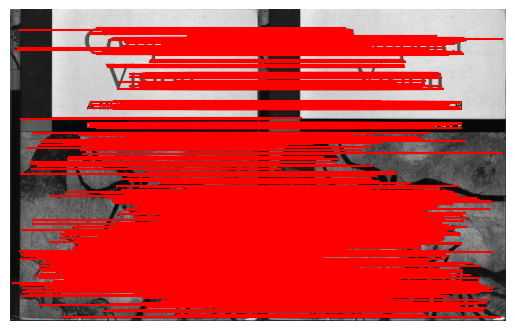

90


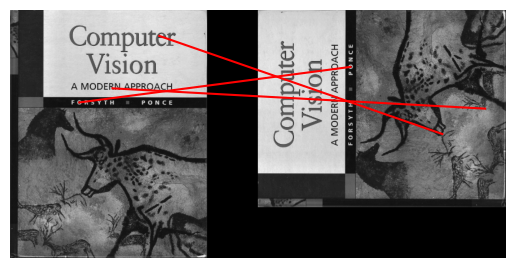

180


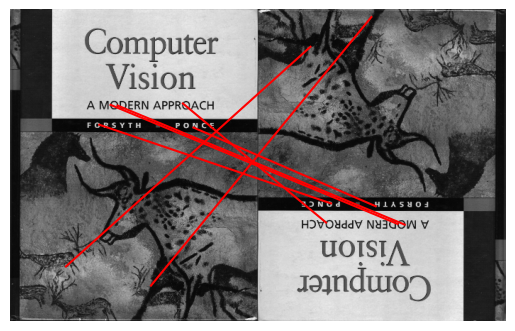

270


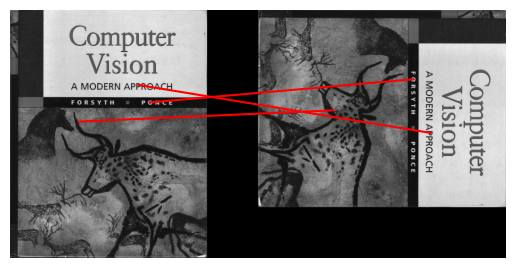

In [8]:
# defaults are:
# min_deg = 0
# max_deg = 360
# deg_inc = 10
# ratio = 0.7
# sigma = 0.15
# filename = 'cv_cover.jpg'

# Controls the rotation degrees
min_deg = 0
max_deg = 360
deg_inc = 90

# Brief feature descriptor and Fast feature detector paremeters
# (change these if you want to use different values)
ratio = 0.7
sigma = 0.15

# image to rotate and match
# (no need to change this but can if you want to experiment)
filename = 'cv_cover.jpg'

# Call briefRot
briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename)

#### Plot the histogram

See debugging tips in handout.

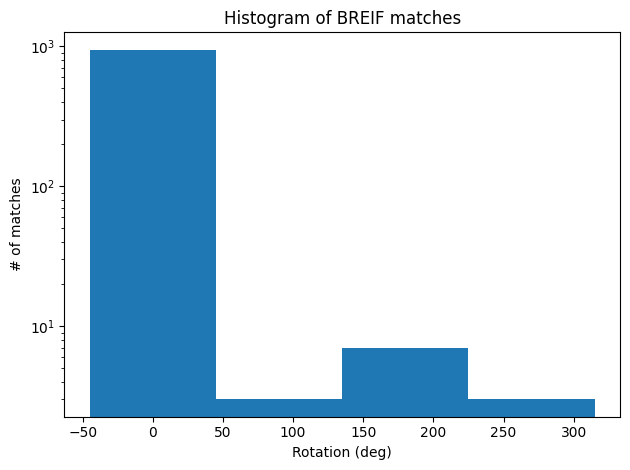

In [9]:
dispBriefRotHist()

---

Explain why you think the BRIEF descriptor behves this way: YOUR ANSWER HERE...

---

### Q2.1.7.1 (Extra Credit - 5 points):

Design a fix to make BRIEF more rotation invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.

In [10]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Feel free to modify the inputs and the function body as necessary
# This is only an outline
def briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Rotation invariant Brief.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)

        # TODO: Brief matcher that is rotation invariant
        # Feel free to define additional helper functions as necessary

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)

        # TODO: Update match_degrees and match_counts (see descriptions above)

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_INV_MATCHES_PATH, matches_to_save)

# ==== end of code ====

#### Visualize your implemented function


In [11]:
min_deg = 0
max_deg = 360
deg_inc = 10
filename = 'cv_cover.jpg'

# ===== your code here! =====
# TODO: Call briefRotInvEc and visualize

# ==== end of code ====


#### Plot Histogram

In [12]:
# dispBriefRotHist(matches_path=ROT_INV_MATCHES_PATH)

---

Compare the histograms with an without rotation invariance. Explain your rotation invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---

### Q2.1.7.2 (Extra Credit - 5 points):

Design a fix to make BRIEF more scale invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.


In [13]:
# ===== your code here! =====
# TODO: Define any helper functions here
# (Feel free to put anything in its own cell)

# TODO: Modify the inputs and the function body as necessary
def briefScaleInvEc(ratio, sigma, filename):

    #Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_scales = [] # stores the scaling factors
    match_counts = [] # stores the number of matches at each scaling factor

    for i in [1]:
        # Scale Image
        image_scale = cv2.resize(image,(int(image.shape[1]/(2**i)),
                                        int(image.shape[0]/(2**i))),
                                 interpolation = cv2.INTER_AREA)

        # TODO: Brief matcher that is scale invariant
        # Feel free to define additional helper functions as necessary

        # Compare to regular matchPics
        matches_orig, locs1_orig, locs2_orig = matchPics(image,
                                                         image_scale,
                                                         ratio, sigma)

        print('plotting non-scale invariant scale: ', 2**i)
        plotMatches(image, image_scale, matches_orig, locs1_orig,
                    locs2_orig)
        print('plotting scale-invariant: ', 2**i)
        plotMatches(image, image_scale, matches, locs1, locs2)

# ==== end of code ====

#### Visualize your implemented function

In [14]:
# ===== your code here! =====
# TODO: Call briefScaleInvEc and visualize
# You may change any parameters and the function body as necessary

filename = 'cv_cover.jpg'

ratio = 0.7
sigma = 0.15

# briefScaleInvEc(ratio, sigma, filename)
# ==== end of code ====

---

Explain your scale invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

---


## Q2.2 Homography Computation

### Q2.2.1 (15 Points):

Implement the function computeH

In [15]:
def computeH(x1, x2):
    """
    Compute the homography between two sets of points

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    # ===== your code here! =====
    # TODO: Compute the homography between two sets of points
    # x1, x2: (N,2), H: (3,3), A: (2*N,9)
    N = x1.shape[0]
    A = np.zeros((2*N,9))
    
    A[0:N,0] = -x2[:,0]
    A[0:N,1] = -x2[:,1]
    A[0:N,2] = -1
    A[0:N,3] = 0
    A[0:N,4] = 0
    A[0:N,5] = 0
    A[0:N,6] = x1[:,0]*x2[:,0]
    A[0:N,7] = x1[:,0]*x2[:,1]
    A[0:N,8] = x1[:,0]

    A[N:2*N,0] = 0
    A[N:2*N,1] = 0
    A[N:2*N,2] = 0
    A[N:2*N,3] = -x2[:,0]
    A[N:2*N,4] = -x2[:,1]
    A[N:2*N,5] = -1
    A[N:2*N,6] = x1[:,1]*x2[:,0]
    A[N:2*N,7] = x1[:,1]*x2[:,1]
    A[N:2*N,8] = x1[:,1]

    b = np.zeros((2*N,1))
    AtA = A.T @ A

    u, s, vt = np.linalg.svd(A)
    eigVal, eigVec = np.linalg.eig(AtA)
    zero_singular_value_indices = np.argmin(eigVal)
    # x = vt[:,zero_singular_value_indices]
    x = vt[-1]
    H2to1 = np.reshape(x,(3,3))
    # ==== end of code ====

    return H2to1

### Q2.2.2 (10 points):

Implement the function computeH_norm

In [16]:
def computeH_norm(x1, x2):
    """
    Compute the homography between two sets of points using normalization

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    # ===== your code here! =====

    # TODO: Compute the centroid of the points
    x1_centroid = np.mean(x1,axis=0)
    x2_centroid = np.mean(x2,axis=0)

    # TODO: Shift the origin of the points to the centroid
    x1_shifted = x1 - x1_centroid
    x2_shifted = x2 - x2_centroid

    # TODO: Normalize the points so that the largest distance from the
    # origin is equal to sqrt(2)
    x1_mag = np.linalg.norm(x1_shifted,ord=2,axis=1,keepdims=True)
    x2_mag = np.linalg.norm(x2_shifted,ord=2,axis=1,keepdims=True)
    x1_max_dis = np.max(x1_mag)
    x2_max_dis = np.max(x2_mag)
    x1_norm = x1_shifted / x1_max_dis * np.sqrt(2)
    x2_norm = x2_shifted / x2_max_dis * np.sqrt(2)

    # TODO: Similarity transform 1
    T1 = np.eye(3)
    T1[0:2,2] = -x1_centroid.T
    scale1 = (1 / x1_max_dis * np.sqrt(2))
    T1[2,2] =1/scale1
    T1 = scale1*T1

    # TODO: Similarity transform 2
    T2 = np.eye(3)
    T2[0:2,2] = -x2_centroid.T
    scale2 = (1 / x2_max_dis * np.sqrt(2))
    T2[2,2] =1/scale2
    T2= scale2*T2

    # TODO: Compute homography
    H_norm = computeH(x1_norm,x2_norm)

    # TODO: Denormalization
    H2to1 = np.linalg.inv(T1) @ H_norm @ T2
    #H2to1 = H2to1 / H2to1[2,2]

    # ==== end of code ====

    return H2to1

### Q2.2.3 (25 points):

Implement RANSAC

In [17]:
def computeH_ransac(locs1, locs2, max_iters, inlier_tol,matches):
    """
    Estimate the homography between two sets of points using ransac

    Input
    -----
    locs1, locs2: Lists of points
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    bestH2to1: 3x3 homography matrix that best transforms locs2 to locs1
    inliers: indices of RANSAC inliers

    """

    # ===== your code here! =====

    # TODO:
    # Compute the best fitting homography using RANSAC
    # given a list of matching points locs1 and loc2
    method = 1
    if (method == 1):
        k = 0
        n = 4
        bestH = np.zeros((3,3))
        x1_index = matches[:,0]
        x2_index = matches[:,1]
        x1 = locs1[x1_index]
        x2 = locs2[x2_index]
        N = x1.shape[0]
        best_inliers = np.zeros(N)
        while (k < max_iters):
            indexs = np.random.choice(x1.shape[0], n, replace=False)
            indexs = indexs[:4]
            x1_sampled = x1[indexs]
            x2_sampled = x2[indexs]

            H = computeH_norm(x1_sampled,x2_sampled)
            # Inliers computation
            x2_stack = np.hstack([x2,np.ones((N,1))])
            x1_tf = x2_stack @ H.T
            x1_norm = x1_tf[:,:2] / x1_tf[:,2:]
            deltaPoints = x1_norm - x1
            deltaMag = np.linalg.norm(deltaPoints,ord=2,axis=1,keepdims=True)
            mask_inlier = deltaMag < inlier_tol
            inliers = np.linalg.norm(x1_norm-x1, axis=1) < inlier_tol
            if (np.sum(inliers) > np.sum(best_inliers)):
                best_inliers = inliers
                bestH = H

            k = k + 1

        bestH2to1 = bestH
    elif (method == 2):
        locs1 = locs1[matches[:,0]] 
        locs2 = locs2[matches[:,1]]
        bestH2to1 = np.eye(3)
        best_inliers = np.zeros(locs1.shape[0])

        for i in range(max_iters):
            # Randomly select 4 points
            idx = np.random.choice(locs1.shape[0], 4, replace=False)
            idx = idx[:4]
            x1s = locs1[idx]
            x2s = locs2[idx]

            H2to1 = computeH_norm(x1s, x2s)
            # Compute inliers

            l2h = np.hstack((locs2, np.ones((locs2.shape[0],1))))
            l1h = l2h @ H2to1.T

            l1h_norm = l1h[:,:2] / l1h[:,2:]
            inliers = np.linalg.norm(l1h_norm-locs1, axis=1) < inlier_tol

            if np.sum(inliers) > np.sum(best_inliers):
                best_inliers = inliers
                bestH2to1 = H2to1
    # ==== end of code ====

    return bestH2to1, best_inliers

### Q2.2.4 (10 points):

#### Implement the function compositeH

In [18]:
def compositeH(H2to1, template, img):
    """
    Returns the composite image.

    Input
    -----
    H2to1: Homography from image to template
    template: template image to be warped
    img: background image

    Returns
    -------
    composite_img: Composite image

    """

    # ===== your code here! =====
    # TODO: Create a composite image after warping the template image on top
    # of the image using the homography
    # H = img.shape[0]
    # W = img.shape[1]
    # M = H2to1
    # M = np.eye(3)
    # newImg = cv2.warpPerspective(template, M, (W,H),flags=cv2.INTER_LINEAR)
    # composite_img = newImg

    mask = cv2.warpPerspective(np.ones_like(template), H2to1, (img.shape[1], img.shape[0]))
    template_warped = cv2.warpPerspective(template, H2to1, (img.shape[1], img.shape[0]))
    # Add the warped image to the image
    composite_img = img.copy()
    composite_img[mask==1] = template_warped[mask==1]
    # ==== end of code ====

    return composite_img

#### Implement the function warpImage

In [19]:
def warpImage(ratio, sigma, max_iters, inlier_tol):
    """
    Warps hp_cover.jpg onto the book cover in cv_desk.png.

    Input
    -----
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    """

    hp_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hp_cover.jpg'))
    cv_cover = skimage.io.imread(os.path.join(DATA_DIR, 'cv_cover.jpg'))
    cv_desk = skimage.io.imread(os.path.join(DATA_DIR, 'cv_desk.png'))
    cv_desk = cv_desk[:, :, :3]

    # ===== your code here! =====

    # TODO: match features between cv_desk and cv_cover using matchPics
    matches, locs1, locs2 = matchPics(cv_desk,cv_cover,ratio,sigma)
    locs1[:,[0,1]] = locs1[:,[1,0]]
    locs2[:,[0,1]] = locs2[:,[1,0]]

    # TODO: Scale matched pixels in cv_cover to size of hp_cover
    hp_cover_resized = cv2.resize(hp_cover,(cv_cover.shape[1],cv_cover.shape[0]))

    # TODO: Get homography by RANSAC using computeH_ransac
    H2to1, inliers = computeH_ransac(locs1,locs2,max_iters,inlier_tol,matches)

    # TODO: Overlay using compositeH to return composite_img
    print(H2to1)
    composite_img = compositeH(H2to1,hp_cover_resized,cv_desk)

    # ==== end of code ====

    plt.imshow(composite_img)
    plt.show()

#### Visualize composite image

C:\Users\Ian Krause\AppData\Local\Temp\ipykernel_19708\50834013.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


[[ 6.92001510e-01 -2.99283652e-01  2.14979218e+02]
 [-1.28626939e-02  2.36798894e-01  1.71888270e+02]
 [-2.15928833e-05 -7.94521575e-04  9.15459385e-01]]


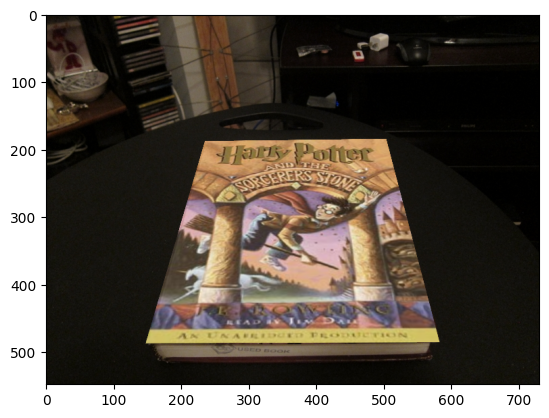

In [20]:
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0

# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

warpImage(ratio, sigma, max_iters, inlier_tol)

### Q2.2.5 (10 points):

Conduct ablation study with various max_iters and inlier_tol values. Plot the result images and explain the effect of these two parameters respectively.

In [21]:
# ===== your code here! =====
# Experiment with different max_iters and inlier_tol values.
# Include the result images in the write-up.

# ==== end of code ====

---

Explain the effect of max_iters and inlier_tol: YOUR ANSWER HERE...

---

# Q3 Create a Simple Panorama

## Q3.1 Create a panorama (10 points):

#### Implement the function createPanorama

In [28]:
def createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol):
    """
    Create a panorama augmented reality application by computing a homography
    and stitching together a left and right image.

    Input
    -----
    left_im: left image
    right_im: right image
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    panorama_im: Stitched together panorama

    """

    # ===== your code here! =====
    # TODO: match features between images
    # This can be done using matchPics, cpselect, or any other function.
    matches, locs1, locs2 = matchPics(left_im,right_im,ratio,sigma)
    locs1[:,[0,1]] = locs1[:,[1,0]]
    locs2[:,[0,1]] = locs2[:,[1,0]]

    # TODO: Get homography by RANSAC using computeH_ransac
    H2to1, inliers = computeH_ransac(locs1,locs2,max_iters,inlier_tol,matches)

    # TODO: Stich together the two images
    # Requires the use of cv2.warpPerspective
    panorama_im = compositeH(H2to1, right_im, left_im)

    # ==== end of code ====

    return panorama_im.astype(np.uint8)

#### Visualize Panorama

Make sure to use **your own images** and **include them as well as the result** in the report.

C:\Users\Ian Krause\AppData\Local\Temp\ipykernel_19708\50834013.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


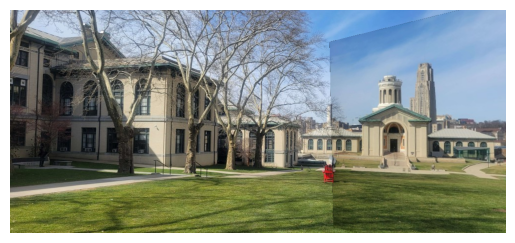

In [29]:
left_im_path = os.path.join(DATA_DIR, 'left_image.jpg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, 'right_image.jpg')
right_im = skimage.io.imread(right_im_path)

# Feel free to adjust as needed
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

panorama_im = createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol)

plt.imshow(panorama_im)
plt.axis('off')
plt.show()